In [1]:
!pip install -r /mnt/c/Users/santhosh/Downloads/MedMamba-main/MedMamba-main/requirements.txt


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [15]:
import sys
sys.path.append('/mnt/c/Users/santhosh/Downloads/MedMamba-main')


In [ ]:
import importlib.util
import sys

module_name = 'MedMamba'
module_path = '/path/to/Medmamba.py'

spec = importlib.util.spec_from_file_location(module_name, module_path)
medmamba = importlib.util.module_from_spec(spec)
sys.modules[module_name] = medmamba
spec.loader.exec_module(medmamba)

In [10]:
import os
import sys
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from tqdm import tqdm
from MedMamba import VSSM as medmamba  # Import VSSM model
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Learning Rate Scheduler

class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        # Load Pretrained EfficientNetB0
        self.efficient_net = models.efficientnet_b0(pretrained=True)
        
        # Remove the final classification layer
        self.efficient_net.classifier = nn.Identity()
        
        # Load Medmamba Model
        self.medmamba_model = medmamba(num_classes=num_classes)

        # Define a new classifier combining both models
        self.classifier = nn.Sequential(
            nn.Linear(1000 + 285, 512),  # Combining EfficientNet & Medmamba outputs
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)  # Final classification layer
        )

    def forward(self, x):
        eff_out = self.efficient_net(x)
        med_out = self.medmamba_model(x)
        combined_out = torch.cat((eff_out, med_out), dim=1) 

        return self.classifier(combined_out)

# Initialize the new model
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device.")

    data_transform = {
        "train": transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        "val": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    }

    train_dataset = datasets.ImageFolder(root="/mnt/c/Users/santhosh/Downloads/MedMamba-main/training",
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    batch_size = 8
    num_classes = len(train_dataset.classes)  # Automatically set number of classes

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=4)

    validate_dataset = datasets.ImageFolder(root="/mnt/c/Users/santhosh/Downloads/MedMamba-main/training",
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)

    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=4)

    print(f"Using {train_num} images for training, {val_num} images for validation.")

    # Load Model
    net = CombinedModel(num_classes=num_classes)
    net.to(device)

    # Loss and Optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    # Learning Rate Scheduler (Reduces LR if val_accuracy plateaus)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

    # Early Stopping Parameters
    early_stop_patience = 10
    no_improvement_epochs = 0

    # Training loop
    epochs = 100
    best_acc = 0.0
    save_path = 'EfficientMedMambaNet.pth'
    torch.cuda.empty_cache()

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, file=sys.stdout)

        for step, data in enumerate(train_bar):
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move to GPU

            optimizer.zero_grad()
            outputs = net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.set_description(f"Epoch [{epoch+1}/{epochs}] Loss: {loss:.4f}")

        # Validation
        net.eval()
        acc = 0.0
        with torch.no_grad():
            val_bar = tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                outputs = net(val_images)
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels).sum().item()

        val_accurate = acc / val_num
        print(f"[Epoch {epoch+1}] Train Loss: {running_loss / len(train_loader):.4f}  Val Accuracy: {val_accurate:.4f}")

        # Reduce LR if validation accuracy doesn't improve
        scheduler.step(val_accurate)

        # Check for Early Stopping
        if val_accurate > best_acc:
            best_acc = val_accurate
            no_improvement_epochs = 0  # Reset counter
            torch.save(net.state_dict(), save_path)
        else:
            no_improvement_epochs += 1  # Increment counter

        if no_improvement_epochs >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation accuracy.")
            break  # Stop training

    print("Finished Training")

if __name__ == '__main__':
    main()


Using cuda:0 device.
Using 3656 images for training, 3656 images for validation.
100%|██████████| 457/457 [00:33<00:00, 13.74it/s]
[Epoch 1] Train Loss: 0.8556  Val Accuracy: 0.7538
100%|██████████| 457/457 [00:33<00:00, 13.55it/s]
[Epoch 2] Train Loss: 0.7153  Val Accuracy: 0.8074
100%|██████████| 457/457 [00:33<00:00, 13.54it/s]
[Epoch 3] Train Loss: 0.6255  Val Accuracy: 0.8025
100%|██████████| 457/457 [00:33<00:00, 13.70it/s]
[Epoch 4] Train Loss: 0.5884  Val Accuracy: 0.8219
100%|██████████| 457/457 [00:33<00:00, 13.47it/s]
[Epoch 5] Train Loss: 0.5835  Val Accuracy: 0.8364
100%|██████████| 457/457 [00:33<00:00, 13.67it/s]
[Epoch 6] Train Loss: 0.5396  Val Accuracy: 0.8539
100%|██████████| 457/457 [00:33<00:00, 13.70it/s]
[Epoch 7] Train Loss: 0.5184  Val Accuracy: 0.8597
100%|██████████| 457/457 [00:33<00:00, 13.83it/s]
[Epoch 8] Train Loss: 0.5144  Val Accuracy: 0.8416
100%|██████████| 457/457 [00:33<00:00, 13.64it/s]
[Epoch 9] Train Loss: 0.4813  Val Accuracy: 0.8578
100%|█████

KeyboardInterrupt: 

In [24]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision import transforms, datasets
import MedMamba  # Import your model class

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the saved model
model = CombinedModel(num_classes=5)  # Replace with your model class
model.load_state_dict(torch.load("/mnt/c/Users/santhosh/Downloads/MedMamba-main/MedMamba-main/EfficientMedMambaNet.pth"))
model.to(device)
model.eval()

from torchvision import transforms, datasets

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load test dataset
test_dataset = datasets.ImageFolder(root="/mnt/c/Users/santhosh/Downloads/MedMamba-main/training", transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get the number of classes
num_classes = len(test_dataset.classes)
class_names = test_dataset.classes


/home/santhosh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/santhosh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
import numpy as np

# Initialize metrics
all_labels = []
all_preds = []
total_loss = 0.0
loss_function = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Compute loss
        loss = loss_function(outputs, labels)
        total_loss += loss.item()

        # Get predictions
        preds = torch.max(outputs, dim=1)[1]
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Compute accuracy
accuracy = np.mean(all_preds == all_labels)

# Compute precision, recall, F1-score for each class
precision = precision_score(all_labels, all_preds, average=None, labels=range(num_classes))
recall = recall_score(all_labels, all_preds, average=None, labels=range(num_classes))
f1 = f1_score(all_labels, all_preds, average=None, labels=range(num_classes))

# Compute overall metrics (macro-average)
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

print(f"Test Loss: {total_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (per class): {precision}")
print(f"Recall (per class): {recall}")
print(f"F1-score (per class): {f1}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")


Test Loss: 0.0320
Test Accuracy: 98.66%
Precision (per class): [0.98092643 0.98987854 0.99833887 0.97202797 0.89952153]
Recall (per class): [0.98901099 0.97897898 0.99889197 0.94237288 0.97409326]
F1-score (per class): [0.98495212 0.98439859 0.99861534 0.95697074 0.93532338]
Precision (macro): 0.9681
Recall (macro): 0.9767
F1-score (macro): 0.9721


In [33]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt  # Importing matplotlib to show the image

# Function to load and predict
def predict_image_class(image_path, model, device):
    # Load the image
    img = Image.open(image_path)
    
    # Define the same transformations as during training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    # Apply transformations
    image = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Ensure the model is on the same device as the input
    model.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)  # Get the predicted class
    
    # Define your class labels
    predictions = ["Mild", "Moderate", "NO_DR", "Proliferate_DR", "Severe"]
    
    # Get the predicted class
    predicted_class = predictions[pred.item()]

    # Display the image with the prediction
    plt.imshow(img)
    plt.axis('off')  # Turn off the axis
    plt.title(f"Prediction: {predicted_class}")
    plt.show()

    # Print the predicted class
    print(f"Predicted class: {predicted_class}")

# Get the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

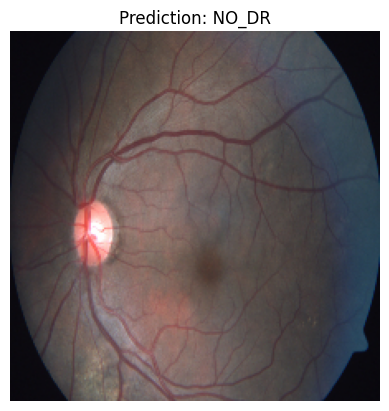

Predicted class: NO_DR


In [32]:
image_path = '/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/No_DR/0a85a1e8f9e9.png' # Replace with your image path
predict_image_class(image_path, model, device)

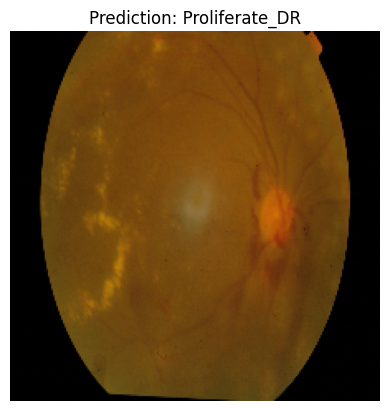

Predicted class: Proliferate_DR


In [34]:
image_path = '/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/Proliferate_DR/1b32e1d775ea.png' # Replace with your image path
predict_image_class(image_path, model, device)